# Analysis of results from L-type Calcium channel ABC calibration

This notebook compares the behaviour of the $I_\text{CaL}$ current in Nygren, Courtemanche and standardised formulations.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math

from typing import List

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyabc import History
from pyabc.weighted_statistics import weighted_mean, weighted_median

import myokit

import pymc3

from ionchannelABC.visualization import plot_variables
from ionchannelABC.utils import weighted_cv

INFO:myokit:Loading Myokit version 1.29.1


## Load pyABC results databases for each run

Assumes that the results databases are stored in a subdirectory called `results'.

Loads history files and converts to dataframes and weights (see pyABC documentation).

In [2]:
def print_results_table(h: History,
                        modelname: str,
                        h_orig: History=None,
                        round_n: int=4,
                        credible_interval: float=0.89,
                        bootstrap_n: int=10000,
                        original: bool=True):
    round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))    
    round_fn = lambda x: round_to_n(x, round_n)
    
    # load df, w for unified and original (if supplied)
    df, w = h.get_distribution()
    if h_orig is not None:
        df_orig, w_orig = h_orig.get_distribution()
    
    params = []
    if original:
        originals = []
    medians = []
    medians_orig = []
    hpd = []
    hpd_orig = []
    rsd = []
    rsd_orig = []

    m = myokit.load_model(modelname)
    
    # need to bootstrap with weights to calculate weighted mean and HPD
    samples = df.sample(n=bootstrap_n, weights=w, replace=True)
    samples = samples.set_index([pd.Index(range(bootstrap_n))])
    
    samples_orig = pd.DataFrame()
    if h_orig is not None:
        samples_orig = df_orig.sample(n=bootstrap_n, weights=w_orig, replace=True)
        samples_orig = samples_orig.set_index([pd.Index(range(bootstrap_n))])
    
    for name in samples.columns:
        params.append(name.split('.')[1])
        if name.startswith('log_'):
            if original:
                originals.append(m.get(name[4:]).value())
            medians.append((10**(samples[name])).median())
            hpd.append(tuple(pymc3.stats.hpd(10**(samples[name]),
                                             credible_interval=credible_interval)))
            if h_orig is not None:
                medians_orig.append((10**(samples_orig[name])).median())
                hpd_orig.append(tuple(pymc3.stats.hpd(10**(samples_orig[name]),
                                                      credible_interval=credible_interval)))
        else:
            if original:
                originals.append(m.get(name).value())
            medians.append(samples[name].median())
            hpd.append(tuple(pymc3.stats.hpd(samples[name],
                                             credible_interval=credible_interval)))
            if h_orig is not None:
                medians_orig.append(samples_orig[name].median())
                hpd_orig.append(tuple(pymc3.stats.hpd(samples_orig[name],
                                                      credible_interval=credible_interval)))
    rsd = weighted_cv(df, w, sample_size=len(df))
    if h_orig is not None:
        rsd_orig = weighted_cv(df_orig, w_orig, sample_size=len(df_orig))
        
    for i, hpd_tuple in enumerate(hpd):
        round_tuple = (round_fn(hpd_tuple[0]),
                       round_fn(hpd_tuple[1]))
        hpd[i] = round_tuple
    for i, hpd_tuple in enumerate(hpd_orig):
        round_tuple = (round_fn(hpd_tuple[0]),
                       round_fn(hpd_tuple[1]))
        hpd_orig[i] = round_tuple
        
    out_dict = {'Name': params}
    if original:
        out_dict = {**out_dict, 'Published': originals}
    if h_orig is not None:
        out_dict = {**out_dict, 'Median (orig)': medians_orig,
                                'HPD'+str(int(credible_interval*100))+' (orig)': hpd_orig,
                                '$log_{10}$RSD (orig)': rsd_orig}
    out_dict = {**out_dict, 'Median (unif)': medians,
                            'HPD'+str(int(credible_interval*100))+' (unif)': hpd,
                            '$log_{10}$RSD (unif)': rsd}
    out_df = pd.DataFrame(out_dict)
    if original:
        out_df['Published'] = out_df['Published'].map(round_fn)
    out_df['Median (unif)'] = out_df['Median (unif)'].map(round_fn)
    out_df['$log_{10}$RSD (unif)'] = np.log10(out_df['$log_{10}$RSD (unif)']).map(round_fn)
    if h_orig is not None:
        out_df['Median (orig)'] = out_df['Median (orig)'].map(round_fn)
        out_df['$log_{10}$RSD (orig)'] = np.log10(out_df['$log_{10}$RSD (orig)']).map(round_fn)

    print(out_df.to_csv(sep='\t', index=False))

#### Nygren

In [3]:
h_nyg_d_original = History('sqlite:///results/nygren/ical/original/nygren_ical_dgate_original.db')
h_nyg_f_original = History('sqlite:///results/nygren/ical/original/nygren_ical_fgates_original.db')

In [4]:
# Nygren uses the same dataset for fgates between original and unified
h_nyg_d_unified = History('sqlite:///results/nygren/ical/unified/nygren_ical_dgate_unified.db')

In [5]:
df_nyg_d_original, w_nyg_d_original = h_nyg_d_original.get_distribution(m=0)
df_nyg_f_original, w_nyg_f_original = h_nyg_f_original.get_distribution(m=0)

In [6]:
df_nyg_d_unified, w_nyg_d_unified = h_nyg_d_unified.get_distribution(m=0)

In [7]:
print_results_table(h_nyg_d_unified, 'models/nygren_ical.mmt', h_orig=h_nyg_d_original)

Name	Published	Median (orig)	HPD89 (orig)	$log_{10}$RSD (orig)	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p1	9.0	2.689	(2.528, 2.906)	-1.29	9.326	(5.125, 10.51)	-0.5683
p2	5.8	5.055	(5.023, 5.083)	-2.416	7.375	(6.679, 8.916)	-0.9407
p4	35.0	-11.51	(-11.6, -11.36)	-2.151	-39.48	(-99.98, 73.46)	0.4508
p5	30.0	18.58	(18.39, 18.85)	-2.078	28.49	(6.446, 49.01)	-0.2817
p3	0.0027	0.1048	(0.09601, 0.1063)	-1.869	0.001129	(1e-07, 0.03017)	-0.2353
p6	0.002	0.009962	(0.009237, 0.01079)	-1.919	0.0009314	(1.093e-07, 0.0009655)	-0.5757



In [8]:
print_results_table(h_nyg_f_original, 'models/nygren_ical.mmt')

Name	Published	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
q1	27.4	31.99	(21.22, 47.51)	-0.5415
q2	7.1	8.076	(1.581, 18.14)	-0.2068
q4	40.0	60.12	(29.37, 99.4)	-0.3934
q5	14.4	25.73	(2.594, 43.99)	-0.2737
r2	40.0	45.8	(11.66, 94.88)	-0.2224
r3	14.2	47.49	(1.119, 89.11)	-0.1519
q3	0.161	0.04211	(1.07e-07, 0.8761)	-0.002009
q6	0.01	0.007543	(0.002444, 0.05933)	-0.5916
r1	1.332	0.05592	(1.136e-07, 2.713)	0.05333
r4	0.0626	0.01098	(1.018e-07, 0.05847)	-0.2101



#### Courtemanche

In [9]:
h_cou_d_original = History('sqlite:///results/courtemanche/ical/original/courtemanche_ical_dgate_original.db')
h_cou_f_original = History('sqlite:///results/courtemanche/ical/original/courtemanche_ical_fgate_original.db')

In [10]:
h_cou_d_unified = History('sqlite:///results/courtemanche/ical/unified/courtemanche_ical_dgate_unified.db')
h_cou_f_unified = History('sqlite:///results/courtemanche/ical/unified/courtemanche_ical_fgate_unified.db')

In [11]:
df_cou_d_original, w_cou_d_original = h_cou_d_original.get_distribution(m=0)
df_cou_f_original, w_cou_f_original = h_cou_f_original.get_distribution(m=0)

In [12]:
df_cou_d_unified, w_cou_d_unified = h_cou_d_unified.get_distribution(m=0)
df_cou_f_unified, w_cou_f_unified = h_cou_f_unified.get_distribution(m=0)

In [13]:
print_results_table(h_cou_d_unified, 'models/courtemanche_ical.mmt', h_orig=h_cou_d_original)

Name	Published	Median (orig)	HPD89 (orig)	$log_{10}$RSD (orig)	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p1	10.0	-63.77	(-90.59, -30.23)	-0.5153	-37.9	(-99.15, 54.69)	0.2831
p2	6.24	9.876	(1.853, 18.57)	-0.2793	19.99	(0.1832, 43.5)	-0.1334
p4	10.0	19.09	(6.624, 20.7)	-0.5022	10.44	(10.05, 10.71)	-1.66
p5	8.0	6.071	(5.647, 7.053)	-1.029	7.447	(7.254, 7.626)	-1.754
p3	0.035	2.071e-07	(1.564e-07, 0.0001668)	-0.6749	0.02429	(0.01361, 0.07017)	-0.7863



In [14]:
print_results_table(h_cou_f_unified, 'models/courtemanche_ical.mmt', h_orig=h_cou_f_original)

Name	Published	Median (orig)	HPD89 (orig)	$log_{10}$RSD (orig)	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
q4	10.0	-11.32	(-72.15, 86.73)	0.8784	1.306	(-1.306, 4.125)	0.07887
q6	28.0	27.83	(25.17, 30.52)	-1.177	33.32	(26.0, 40.27)	-0.8614
q7	6.9	6.885	(5.479, 8.937)	-0.8052	10.95	(7.383, 14.02)	-0.704
q1	9.0	59.65	(1.038, 444.8)	-0.372	5.289	(1.004, 19.95)	-0.2447
q2	0.0197	0.2562	(0.01006, 3.054)	0.2592	1.852	(0.1682, 6.422)	0.3113
q3	0.0337	0.01257	(0.0001002, 0.1904)	-0.3061	0.1139	(0.08042, 0.1534)	-1.006
q5	0.02	0.02405	(0.0001017, 0.4227)	-0.1906	0.1929	(0.03626, 0.6931)	-0.2331



#### Standardised

In [15]:
h_sta = History('sqlite:///results/standardised/ical/standardised_ical.db')

In [16]:
df_sta, w_sta = h_sta.get_distribution(m=0)

In [17]:
print_results_table(h_sta, 'models/standardised_ical.mmt')

Name	Published	Median (unif)	HPD89 (unif)	$log_{10}$RSD (unif)
p_2	0.014	0.01894	(2.23e-06, 0.0593)	-0.07143
p_4	0.058	0.09849	(0.02356, 0.2517)	-0.1811
p_6	0.11	0.04434	(0.03068, 0.06141)	-0.6387
p_8	0.051	0.02451	(0.01325, 0.03353)	-0.5575
A	10.0	4.465	(3.181, 13.56)	-0.5354
p_1	19.95	0.5519	(1.03e-07, 1.094)	0.1053
p_3	0.3981	0.3749	(0.0056, 1.586)	0.07778
p_5	158.5	0.06439	(0.04193, 0.2338)	-0.6597
p_7	0.000631	0.02035	(0.01379, 0.02847)	-1.205



## Compare number of gating parameters in models

Generate bar plot using manually input numbers. See models and publications for source.

In [18]:
parameter_number = pd.DataFrame([['N',6,10],['C',5,7],['S',4,5]], 
                                columns = ['model', 'act', 'inact'])

In [19]:
parameter_number.inact = parameter_number.act + parameter_number.inact

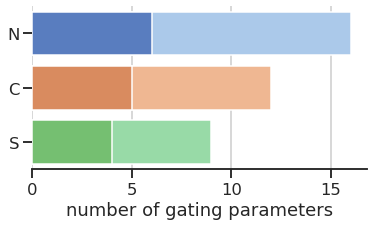

In [20]:
sns.set(style="ticks")
sns.set_context("talk")
sns.set_color_codes("pastel")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="inact", y="model", hue="model", data=parameter_number,
            palette="pastel", dodge=False)

sns.set_color_codes("muted")
sns.barplot(x="act", y="model", hue="model", data=parameter_number,
            palette="muted", dodge=False)

handles, labels = ax.get_legend_handles_labels()
order = []
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          ncol=2, loc="lower right", frameon=False)
ax.set(xlabel="number of gating parameters")
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(left=True)

In [22]:
#f.savefig('figures/ical/param_num_compare.pdf')

## Compare calibration between original and unified datasets

Plot relative standard deviation (RSD) of parameter posteriors and gating functions for Nygren and Courtemanche using the original dataset and unified datasets.

Note: we use the term RSD instead of CV (coefficient of variation) to avoid confusion with conduction velocity.

#### Calculate RSD values for Nygren and Courtemanche models

In [23]:
rsd_nyg_d_original = weighted_cv(df_nyg_d_original, w_nyg_d_original, sample_size=len(df_nyg_d_original))
rsd_nyg_f_original = weighted_cv(df_nyg_f_original, w_nyg_f_original, sample_size=len(df_nyg_f_original))

rsd_nyg_original = pd.concat([rsd_nyg_d_original, rsd_nyg_f_original])
model = ['N',]*len(rsd_nyg_original)
data = ['ORIGINAL',]*len(rsd_nyg_original)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_original}
nyg_original = pd.DataFrame(frame)

In [24]:
rsd_nyg_d_unified = weighted_cv(df_nyg_d_unified, w_nyg_d_unified, sample_size=len(df_nyg_d_unified))

rsd_nyg_unified = pd.concat([rsd_nyg_d_unified, rsd_nyg_f_original])
model = ['N',]*len(rsd_nyg_unified)
data = ['UNIFIED',]*len(rsd_nyg_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_nyg_unified}
nyg_unified = pd.DataFrame(frame)

In [25]:
rsd_cou_d_original = weighted_cv(df_cou_d_original, w_cou_d_original, sample_size=len(df_cou_d_original))
rsd_cou_f_original = weighted_cv(df_cou_f_original, w_cou_f_original, sample_size=len(df_cou_f_original))

rsd_cou_original = pd.concat([rsd_cou_d_original, rsd_cou_f_original])
model = ['C',]*len(rsd_cou_original)
data = ['ORIGINAL',]*len(rsd_cou_original)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_original}
cou_original = pd.DataFrame(frame)

In [26]:
rsd_cou_d_unified = weighted_cv(df_cou_d_unified, w_cou_d_unified, sample_size=len(df_cou_d_unified))
rsd_cou_f_unified = weighted_cv(df_cou_f_unified, w_cou_f_unified, sample_size=len(df_cou_f_unified))

rsd_cou_unified = pd.concat([rsd_cou_d_unified, rsd_cou_f_unified])
model = ['C',]*len(rsd_cou_unified)
data = ['UNIFIED',]*len(rsd_cou_unified)
frame = {'model': model, 'data': data, 'RSD': rsd_cou_unified}
cou_unified = pd.DataFrame(frame)

In [27]:
rsd_compare = pd.concat([nyg_original, nyg_unified, cou_original, cou_unified])#, cou_reported, cou])

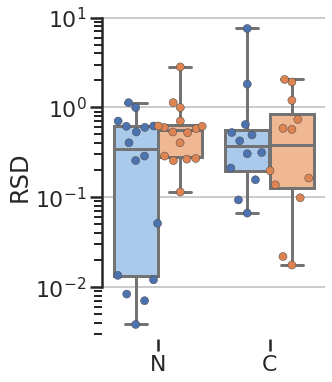

In [28]:
sns.set(style="ticks")
sns.set_context("poster")

# Initialize the figure
f, ax = plt.subplots(figsize=(4, 6))

# Plot the boxplot summary of RSD
sns.boxplot(x="model", y="RSD", hue="data", data=rsd_compare,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="model", y="RSD", hue="data", data=rsd_compare,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="RSD")
ax.set_yscale('log')
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)
ax.get_legend().remove()

In [29]:
diff = nyg_unified.RSD-nyg_original.RSD
stats.wilcoxon(diff)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)

In [30]:
stats.mannwhitneyu(rsd_compare[(rsd_compare.model=='N') & (rsd_compare.data=='ORIGINAL')].RSD, 
                   rsd_compare[(rsd_compare.model=='C') & (rsd_compare.data=='ORIGINAL')].RSD)

MannwhitneyuResult(statistic=80.0, pvalue=0.2358950681666513)

In [31]:
stats.mannwhitneyu(rsd_compare[(rsd_compare.model=='N') & (rsd_compare.data=='UNIFIED')].RSD, 
                   rsd_compare[(rsd_compare.model=='C') & (rsd_compare.data=='UNIFIED')].RSD)

MannwhitneyuResult(statistic=78.0, pvalue=0.20827616740584248)

In [33]:
#f.savefig('figures/ical/rsd_compare.pdf')

#### Compare underlying gating functions for each model

Sample from posterior particle population and plot resulting gating functions

In [19]:
# Number of parameter samples
N = 100

In [35]:
nyg_par_samples_d_original = df_nyg_d_original.sample(n=N, weights=w_nyg_d_original, replace=True)
nyg_par_samples_d_original = nyg_par_samples_d_original.set_index([pd.Index(range(N))])
nyg_par_samples_f_original = df_nyg_f_original.sample(n=N, weights=w_nyg_f_original, replace=True)
nyg_par_samples_f_original = nyg_par_samples_f_original.set_index([pd.Index(range(N))])

nyg_par_samples_original = (pd.concat([nyg_par_samples_d_original, 
                                       nyg_par_samples_f_original],axis=1)
                            .to_dict(orient='records'))

In [36]:
nyg_par_samples_d_unified = df_nyg_d_unified.sample(n=N, weights=w_nyg_d_unified, replace=True)
nyg_par_samples_d_unified = nyg_par_samples_d_unified.set_index([pd.Index(range(N))])
nyg_par_samples_unified = (pd.concat([nyg_par_samples_d_unified, 
                                      nyg_par_samples_f_original], axis=1)
                           .to_dict(orient='records'))

In [23]:
v = np.arange(-100, 50, 0.5)

nyg_par_map = {'di': 'ical.d_inf',
                'dt': 'ical.tau_d',
                'fi1': 'ical.f_inf',
                'ft1': 'ical.tau_f_1',            
                'fi2': 'ical.f_inf',
                'ft2': 'ical.tau_f_2'}

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


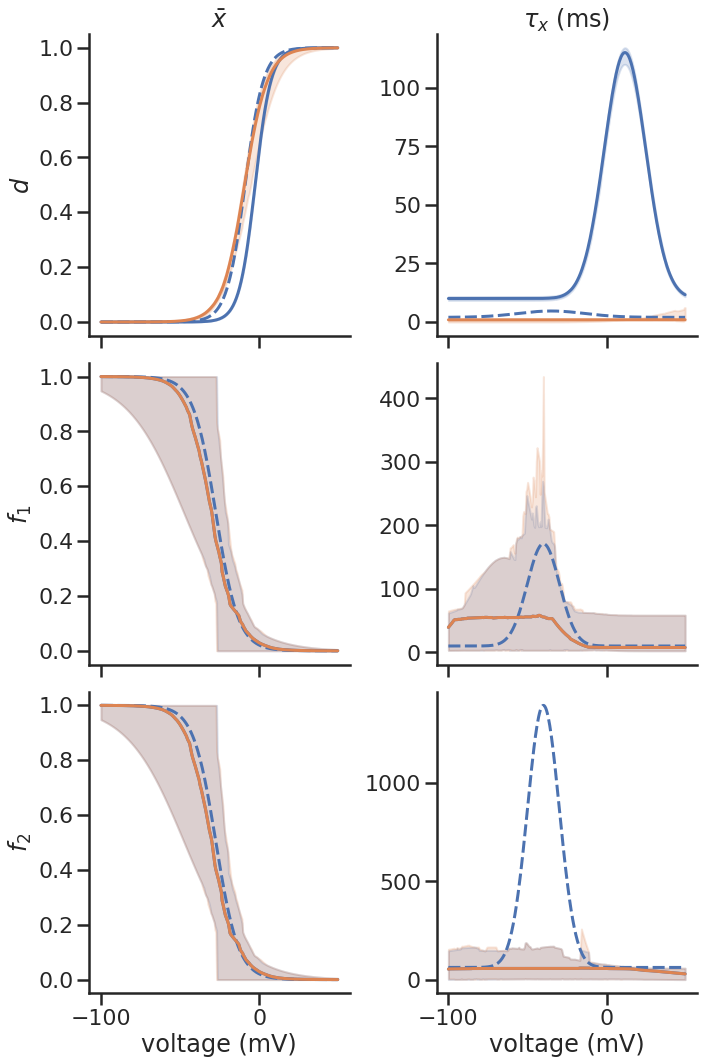

In [38]:
sns.set_context('poster')
sns.set_palette('deep')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_par_map, nyg_par_map], 
                       ['models/nygren_ical.mmt', 'models/nygren_ical_.mmt'], 
                       [nyg_par_samples_original, nyg_par_samples_unified],
                       original=[True,False],
                       figshape=(2,3))

ax[0][0].set_ylabel(r'$d$')
ax[1][0].set_ylabel(r'$f_1$')
ax[2][0].set_ylabel(r'$f_2$')
ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')
for a in ax[:,1].flatten():
    a.set_ylabel('')
for a in ax[2][:]:
    a.set_xlabel('voltage (mV)')

#lim=200
#ax[0][1].set_ylim((-0.05*lim, 1.05*lim))
#lim=2000
#ax[1][1].set_ylim((-0.05*lim, 1.05*lim))
#lim=2000
#ax[2][1].set_ylim((-0.05*lim, 1.05*lim))
    
plt.tight_layout()

In [40]:
#f.savefig('figures/ical/nyg_gating_functions.pdf')

In [20]:
cou_par_samples_d_original = df_cou_d_original.sample(n=N, weights=w_cou_d_original, replace=True)
cou_par_samples_d_original = cou_par_samples_d_original.set_index([pd.Index(range(N))])
cou_par_samples_f_original = df_cou_f_original.sample(n=N, weights=w_cou_f_original, replace=True)
cou_par_samples_f_original = cou_par_samples_f_original.set_index([pd.Index(range(N))])
cou_par_samples_original = (pd.concat([cou_par_samples_d_original, 
                                       cou_par_samples_f_original],axis=1)
                            .to_dict(orient='records'))

cou_par_samples_d_unified = df_cou_d_unified.sample(n=N, weights=w_cou_d_unified, replace=True)
cou_par_samples_d_unified = cou_par_samples_d_unified.set_index([pd.Index(range(N))])
cou_par_samples_f_unified = df_cou_f_unified.sample(n=N, weights=w_cou_f_unified, replace=True)
cou_par_samples_f_unified = cou_par_samples_f_unified.set_index([pd.Index(range(N))])
cou_par_samples_unified = (pd.concat([cou_par_samples_d_unified,
                                      cou_par_samples_f_unified], axis=1)
                           .to_dict(orient='records'))

In [21]:
cou_par_map = {'di': 'ical.d_inf',
               'dt': 'ical.tau_d',
               'fi': 'ical.f_inf',
               'ft': 'ical.tau_f'}

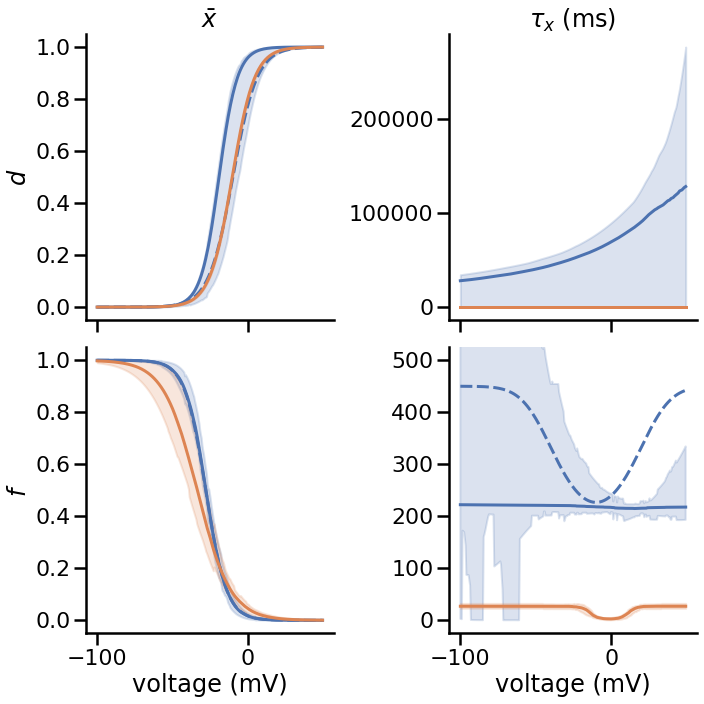

In [26]:
from ionchannelABC.visualization import plot_variables
sns.set_context('poster')
sns.set_palette('deep')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [cou_par_map, cou_par_map], 
                       ['models/courtemanche_ical.mmt', 'models/courtemanche_ical_.mmt'], 
                       [cou_par_samples_original, cou_par_samples_unified],
                       original=[True,False],
                       figshape=(2,2))

ax[0][0].set_ylabel(r'$d$')
ax[1][0].set_ylabel(r'$f$')

ax[0][0].set_title(r'$\bar{x}$')
ax[0][1].set_title(r'$\tau_x$ (ms)')

for a in ax[:,1].flatten():
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage (mV)')

#ax[0,1].set_ylim((-0.05*5, 1.05*5))
ax[1,1].set_ylim((-0.05*500, 1.05*500))
    
plt.tight_layout()

In [49]:
#f.savefig('figures/ical/cou_gating_functions.pdf')

## Compare all models calibrated to unified dataset

### RSD of parameter posteriors

In [50]:
rsd_sta = weighted_cv(df_sta, w_sta, sample_size=len(df_sta))
model = ['S',]*len(rsd_sta)
frame = {'model': model, 'RSD': rsd_sta}
sta = pd.DataFrame(frame)

In [51]:
rsd_unified = pd.concat([nyg_unified, cou_unified, sta], sort=False)

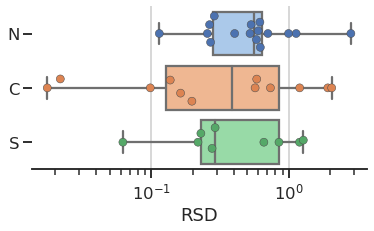

In [52]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x="RSD", y="model", data=rsd_unified,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x="RSD", y="model", data=rsd_unified,
              linewidth=0.5, size=8, dodge=True)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set_xscale("log")
ax.set(ylabel="")
sns.despine(left=True)

In [54]:
#f.savefig('figures/ical/rsd_compare_unified.pdf')

In [55]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=66.0, pvalue=0.3777573283694211)

In [56]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='C'].RSD, 
                   rsd_unified[rsd_unified.model=='S'].RSD)

MannwhitneyuResult(statistic=46.0, pvalue=0.29701617029952077)

In [57]:
stats.mannwhitneyu(rsd_unified[rsd_unified.model=='N'].RSD, 
                   rsd_unified[rsd_unified.model=='C'].RSD)

MannwhitneyuResult(statistic=78.0, pvalue=0.20827616740584248)

### Residuals to experimental data

In [58]:
# Sample number
N = 100

In [59]:
eps_nyg_d = h_nyg_d_unified.get_weighted_distances()
eps_nyg_f = h_nyg_f_original.get_weighted_distances()

eps_nyg = np.array([])
eps_nyg = (np.array(eps_nyg_d.sample(n=N, axis=0, weights=eps_nyg_d.w, replace=True).distance) +
           np.array(eps_nyg_f.sample(n=N, axis=0, weights=eps_nyg_f.w, replace=True).distance))
eps_nyg = pd.DataFrame({'model': 'N', 'eps': eps_nyg, 'exp': 'all'})

In [60]:
eps_cou_d = h_cou_d_unified.get_weighted_distances()
eps_cou_f = h_cou_f_unified.get_weighted_distances()

eps_cou = np.array([])
eps_cou = (np.array(eps_cou_d.sample(n=N,axis=0,weights=eps_cou_d.w,replace=True).distance) +
           np.array(eps_cou_f.sample(n=N,axis=0,weights=eps_cou_f.w,replace=True).distance))

eps_cou = pd.DataFrame({'model': 'C', 'eps': eps_cou, 'exp': 'all'})

In [61]:
eps_sta = h_sta.get_weighted_distances()
eps_sta = eps_sta.sample(n=100,axis=0,weights=eps_sta.w,replace=True).distance
eps_sta = pd.DataFrame({'model': 'S', 'eps': eps_sta, 'exp': 'all'})

In [62]:
eps = pd.concat([eps_nyg, eps_cou, eps_sta])

In [63]:
eps['normalised'] = (eps['eps']-eps['eps'].min())/(eps['eps'].max()-eps['eps'].min())

Text(0, 0.5, 'residual')

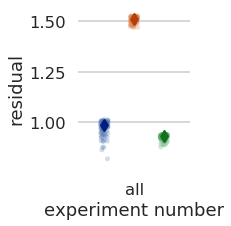

In [64]:
sns.set_context("talk")
sns.set_style("whitegrid")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

f, ax = plt.subplots(figsize=(2, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=eps, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=eps,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

ax.get_legend().remove()
ax.set_xlabel('experiment number')
ax.set_ylabel('residual')

In [66]:
#f.savefig('figures/ical/eps_all_stripplot.pdf')

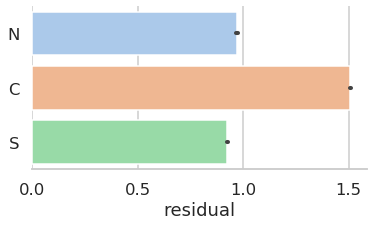

In [67]:
sns.set_context('talk')

f, ax = plt.subplots(figsize=(6,3))

sns.barplot(x="eps", y="model", data=eps, palette='pastel')

ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="residual")
sns.despine(left=True)

In [69]:
#f.savefig('figures/ical/eps_all_barplot.pdf')

Below we sample from the posterior particle populations and run the calibration experiments to be able to calculate a per-experiment epsilon value.

In [70]:
nyg_par_samples_d = df_nyg_d_unified.sample(n=N, weights=w_nyg_d_unified, replace=True)
nyg_par_samples_d = nyg_par_samples_d.set_index([pd.Index(range(N))])
nyg_par_samples_d = nyg_par_samples_d.to_dict(orient='records')

nyg_par_samples_f = df_nyg_f_original.sample(n=N, weights=w_nyg_f_original, replace=True)
nyg_par_samples_f = nyg_par_samples_f.set_index([pd.Index(range(N))])
nyg_par_samples_f = nyg_par_samples_f.to_dict(orient='records')

cou_par_samples_d = df_cou_d_unified.sample(n=N, weights=w_cou_d_unified, replace=True)
cou_par_samples_d = cou_par_samples_d.set_index([pd.Index(range(N))])
cou_par_samples_d = cou_par_samples_d.to_dict(orient='records')

cou_par_samples_f = df_cou_f_unified.sample(n=N, weights=w_cou_f_unified, replace=True)
cou_par_samples_f = cou_par_samples_f.set_index([pd.Index(range(N))])
cou_par_samples_f = cou_par_samples_f.to_dict(orient='records')

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

In [71]:
from ionchannelABC.experiment import setup
from ionchannelABC.distance import IonChannelDistance

In [75]:
from experiments.ical_li import (li_act,
                                 li_act_tau,
                                 li_inact_1000,
                                 li_inact_kin_tauf_80,
                                 li_inact_kin_taus_80,
                                 li_recov_tauf,
                                 li_recov_taus)
experiments = [li_act,
               li_act_tau,
               li_inact_1000,
               li_inact_kin_tauf_80,
               li_inact_kin_taus_80,
               li_recov_tauf,
               li_recov_taus]
models = ['models/nygren_ical_temp_adj.mmt',
          'models/courtemanche_ical.mmt',
          'models/standardised_ical.mmt']
pars = [[nyg_par_samples_d, nyg_par_samples_f], 
        [cou_par_samples_d, cou_par_samples_f],
        std_par_samples]
names = ['N','C','S']

In [76]:
def experiment_dist(pars, modelfile, experiment):
    eps = []
    observ, model, sum_stats = setup(modelfile,
                                     experiment)
    obs = observ.to_dict()['y']
    obs = {str(k): v for k, v in obs.items()}
    dist = IonChannelDistance(exp_id=list(observ.exp_id),
                              variance=list(observ.variance),
                              delta=0.05)
    for sample in pars:
        eps.append(dist(sum_stats(model(sample)), obs, None))    
    return eps

The below cell calculates the per-experiment distance and may take some time to run depending on number of samples.

In [77]:
df = pd.DataFrame({})
mask = [[0, 0, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1], None]
for j, exp in enumerate(experiments):
    df_ = pd.DataFrame({})
    for i, m in enumerate(models):
        if mask[i] is not None:
            eps = np.array(
                experiment_dist(pars[i][mask[i][j]],
                                m,
                                exp)
                )
        else:
            eps = np.array(
                experiment_dist(pars[i],
                                m,
                                exp)
                )
        df_ = df_.append(pd.DataFrame({'model': names[i],
                                       'exp': str(j),
                                       'eps': eps[~np.isinf(eps)]}))
    eps_max = df_['eps'].max()
    eps_min = df_['eps'].min()
    df_['eps'] = (df_['eps'] - eps_min)/(eps_max-eps_min)
    df = df.append(df_)

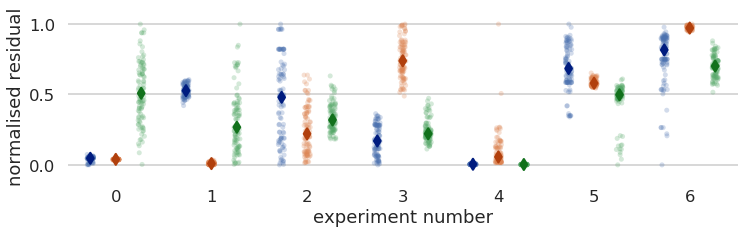

In [78]:
sns.set_context("talk")
sns.set_style("whitegrid")

mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14

fig, ax = plt.subplots(figsize=(12, 3))
sns.despine(bottom=True, left=True)

sns.stripplot(x='exp', y='eps', hue='model', data=df, 
              dodge=True, jitter=True, alpha=.25, zorder=1,
              palette='deep', ax=ax)

sns.pointplot(x="exp", y="eps", hue="model",
              data=df,
              estimator=np.median,
              dodge=.532, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="model",
          handletextpad=0, columnspacing=1,
          loc="best", ncol=3, frameon=True)
ax.set_xlabel('experiment number')
ax.set_ylabel('normalised residual')
ax.get_legend().remove()

In [80]:
#fig.savefig('figures/ical/eps_per_exp_stripplot.pdf')

### Summary statistics compared to experimental data

In [18]:
from experiments.ical_li import (li_act_and_tau,
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

In [19]:
from ionchannelABC.visualization import plot_data_adjustment

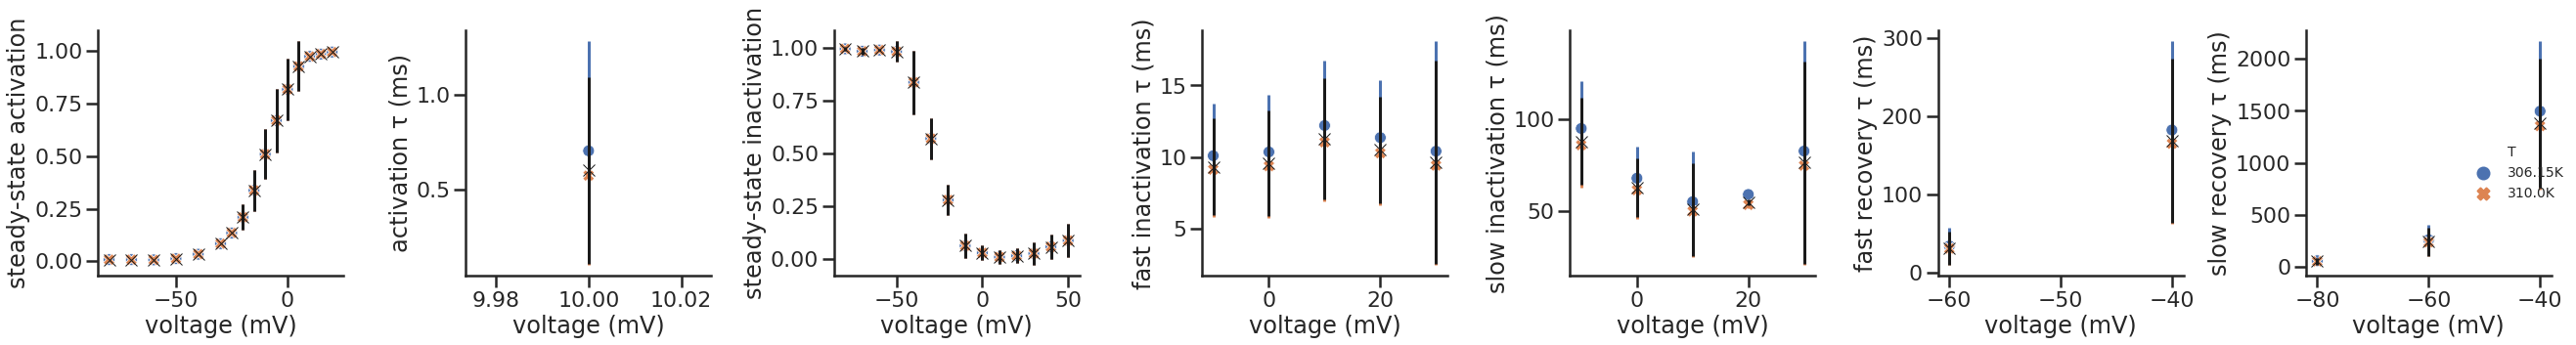

In [83]:
sns.set(style="ticks")
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_data_adjustment(['models/nygren_ical.mmt',
                          'models/courtemanche_ical.mmt'],
                         li_act_and_tau,
                         li_inact_1000,
                         li_inact_kin_80,
                         li_recov)

ylabels = ["steady-state activation", "activation τ (ms)", "steady-state inactivation",
           "fast inactivation τ (ms)", "slow inactivation τ (ms)", "fast recovery τ (ms)", 
           "slow recovery τ (ms)"]
for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

In [24]:
#g.savefig('ical_data_adjustment.pdf')

In [20]:
from ionchannelABC.visualization import plot_sim_results

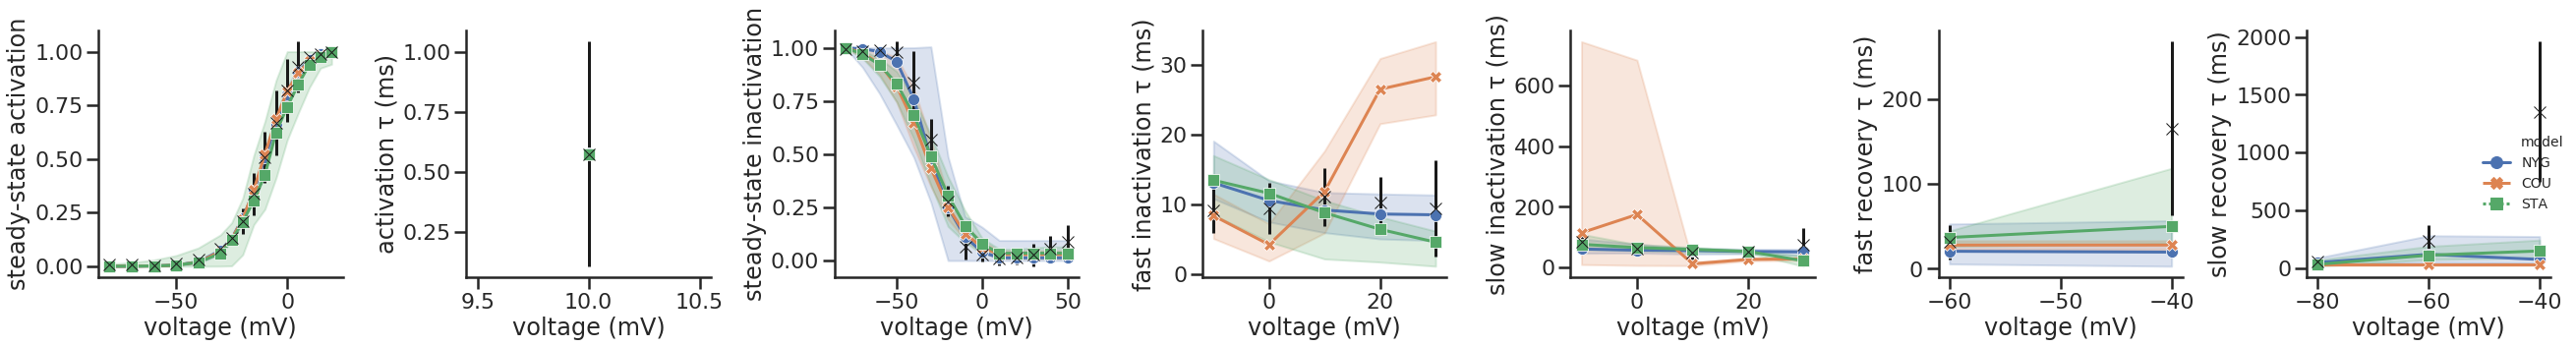

In [21]:
sns.set(style='ticks')
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(['models/nygren_ical.mmt',
                      'models/nygren_ical.mmt',
                      'models/courtemanche_ical.mmt',
                      'models/courtemanche_ical.mmt',
                      'models/standardised_ical.mmt'],
                     li_act_and_tau,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     temp_match_model = 4, # scale to match S model temperature
                     masks=[[(0,1)]+[None,]*3,
                            [None]+[2,(3,4),(5,6)],
                            [(0,1)]+[None,]*3,
                            [None,]+[2,(3,4),(5,6)],
                            None],
                     df=[df_nyg_d_unified,
                         df_nyg_f_original,
                         df_cou_d_unified,
                         df_cou_f_unified,
                         df_sta], 
                     w=[w_nyg_d_unified,
                        w_nyg_f_original,
                        w_cou_d_unified,
                        w_cou_f_unified,
                        w_sta])

ylabels = ["steady-state activation", "activation τ (ms)", "steady-state inactivation",
           "fast inactivation τ (ms)", "slow inactivation τ (ms)", "fast recovery τ (ms)", 
           "slow recovery τ (ms)"]
for ax in g.axes.flatten():
    ax.set_xlabel("voltage (mV)")
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax in g.axes.flatten():
    ax.set_title("")

plt.tight_layout()

In [23]:
#g.savefig('figures/ical/compare_summary_statistics.pdf')

### Gating functions compared between models

In [19]:
nyg = 'models/nygren_ical_temp_adj.mmt' # temperature adjusted by scaling time constants
cou ='models/courtemanche_ical.mmt'
std = 'models/standardised_ical.mmt'

In [20]:
v = np.arange(-80, 50, 0.5)

In [21]:
nyg_par_map = {'di': 'ical.d_inf',
               'fi1': 'ical.f_inf',
               'fi2': 'ical.f_inf',
               'dt': 'ical.tau_d',
               'ft1': 'ical.tau_f_1',            
               'ft2': 'ical.tau_f_2'}

In [22]:
# COU only has one gate so plot on both inactivation plots
cou_par_map = {'di': 'ical.d_inf',
               'fi1': 'ical.f_inf',
               'fi2': 'ical.f_inf',
               'dt': 'ical.tau_d',
               'ft1': 'ical.tau_f',
               'ft2': 'ical.tau_f'}

In [23]:
std_par_map = {'di': 'ical.d_ss',
               'fi1': 'ical.f_ss',
               'fi2': 'ical.f_ss',
               'dt': 'ical.tau_d',
               'ft1': 'ical.tau_f1',
               'ft2': 'ical.tau_f2'}

In [24]:
N = 100

nyg_par_samples_d_unified = df_nyg_d_unified.sample(n=N, weights=w_nyg_d_unified, replace=True)
nyg_par_samples_d_unified = nyg_par_samples_d_unified.set_index([pd.Index(range(N))])
nyg_par_samples_f_original = df_nyg_f_original.sample(n=N, weights=w_nyg_f_original, replace=True)
nyg_par_samples_f_original = nyg_par_samples_f_original.set_index([pd.Index(range(N))])
nyg_par_samples = (pd.concat([nyg_par_samples_d_unified, 
                              nyg_par_samples_f_original],axis=1)
                   .to_dict(orient='records'))

cou_par_samples_d = df_cou_d_unified.sample(n=N, weights=w_cou_d_unified, replace=True)
cou_par_samples_d = cou_par_samples_d.set_index([pd.Index(range(N))])
cou_par_samples_f = df_cou_f_unified.sample(n=N, weights=w_cou_f_unified, replace=True)
cou_par_samples_f = cou_par_samples_f.set_index([pd.Index(range(N))])
cou_par_samples = (pd.concat([cou_par_samples_d,
                              cou_par_samples_f],axis=1)
                   .to_dict(orient='records'))

std_par_samples = df_sta.sample(n=N, weights=w_sta, replace=True)
std_par_samples = std_par_samples.set_index([pd.Index(range(N))])
std_par_samples = std_par_samples.to_dict(orient='records')

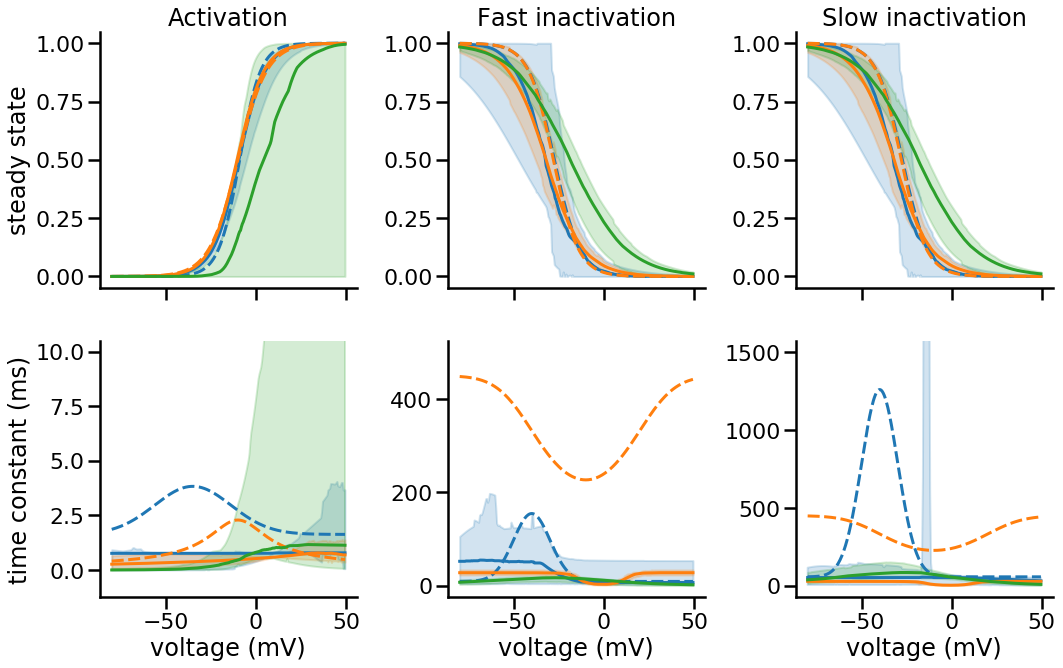

In [27]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_par_map, cou_par_map, std_par_map], 
                       [nyg, cou, std], 
                       [nyg_par_samples, cou_par_samples, std_par_samples],
                       original=[True, True, False],
                       figshape=(3,2))

ax[0][0].set_ylabel('steady state')
ax[1][0].set_ylabel('time constant (ms)')
ax[0][0].set_title('Activation')
ax[0][1].set_title('Fast inactivation')
ax[0][2].set_title('Slow inactivation')

for a in ax[0,:]:
    a.set_ylim((-0.05, 1.05))
    
ax[1,0].set_ylim(-0.05*25, 10+0.05*10)
ax[1,1].set_ylim(-0.05*500, 500+0.05*500)
ax[1,2].set_ylim(-0.05*1500, 1500+0.05*1500)

for a in ax[:,1:].flatten():
    a.set_ylabel('')
    
for a in ax[1,:]:
    a.set_xlabel('voltage (mV)')
    
for a in ax.flatten():
    x0,x1 = a.get_xlim()
    y0,y1 = a.get_ylim()
    a.set_aspect(abs(x1-x0)/abs(y1-y0))
    
plt.tight_layout()

In [29]:
#f.savefig('figures/ical/compare_gating_functions.pdf')

### Compare final pulse after pulse train

In [40]:
import myokit

In [41]:
nsteps = 100
period = 1000
tstep = 200
vhold = -80
vstep = -10

pulsetrain = myokit.pacing.steptrain([vstep,]*nsteps,
                                     vhold,
                                     period-tstep,
                                     tstep)

In [42]:
# nygren_ina_temp_adj has had tau values adjusted for temperature to 310K
models = [myokit.load_model(modelfile) for modelfile in ['models/nygren_ical_temp_adj.mmt',
                                                         'models/courtemanche_ical.mmt',
                                                         'models/standardised_ical.mmt']]
for m in models:
    pace = m.get('membrane.V')
    if pace.binding() != 'pace':
        if pace.is_state():
            pace.demote()
        pace.set_rhs(0)
        pace.set_binding('pace')

In [43]:
sims = [myokit.Simulation(m, pulsetrain) for m in models]

In [44]:
par_samples = [nyg_par_samples, cou_par_samples, std_par_samples]

In [45]:
import time

all_samples = pd.DataFrame({})
for i, s in enumerate(sims):
    s.reset()
    # store original
    if models[i].name() != 'STA':
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ical.g','engine.time','membrane.V'],
                        log_interval=0.5)
        datalog = datalog.trim((nsteps)*period-tstep-20, (nsteps)*period, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ical.g']/max(datalog['ical.g']),
              'sample': 0,
              'model': models[i].name(),
              'type': 'original'}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)
    
    # re-calibrated
    for j, par_sample in enumerate(par_samples[i]):
        s.reset()
        for p, v in par_sample.items():
            name = p
            value = v
            if p.startswith("log"):
                name = p[4:]
                value = 10**v
            s.set_constant(name, value)
            
        # Log run time for comparisons
        t0 = time.time()
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ical.g','engine.time','membrane.V'],
                        log_interval=1)
        t1 = time.time()
        dt = t1-t0
        
        datalog = datalog.trim((nsteps)*period-tstep-20, (nsteps)*period, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ical.g']/max(datalog['ical.g']),
              'sample': j,
              'model': models[i].name(),
              'type': 'recalibrated',
              'runtime': dt}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [46]:
recalibrated_df = all_samples[all_samples['type']=='recalibrated']

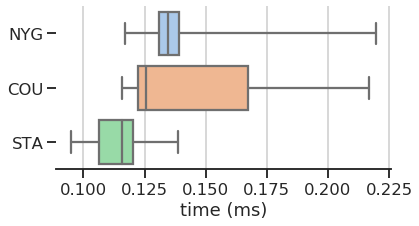

In [47]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(x='runtime', y='model', data=recalibrated_df,
            palette="pastel", whis="range")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
ax.set(xlabel="time (ms)")
sns.despine(left=True)

In [49]:
#f.savefig('figures/ical/runtime_compare.pdf')

In [1]:
stats.mannwhitneyu(recalibrated_df[recalibrated_df.model=='STA'].runtime, 
                   recalibrated_df[recalibrated_df.model=='COU'].runtime,
                   alternative='two-sided')

NameError: name 'stats' is not defined

In [41]:
stats.mannwhitneyu(recalibrated_df[recalibrated_df.model=='COU'].runtime, 
                   recalibrated_df[recalibrated_df.model=='NYG'].runtime,
                   alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [42]:
stats.mannwhitneyu(recalibrated_df[recalibrated_df.model=='STA'].runtime, 
                   recalibrated_df[recalibrated_df.model=='NYG'].runtime,
                   alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [50]:
all_samples_detail = all_samples[(all_samples['time']>=19) & (all_samples['time'] < 30)]

Text(0.5, 1.0, '')

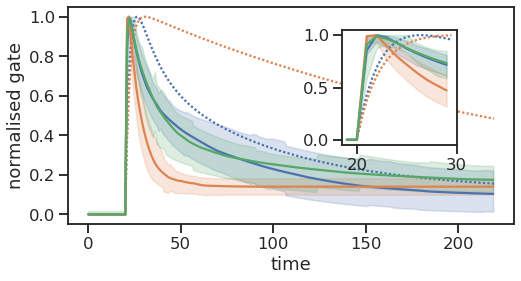

In [51]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(8,4))

g = sns.lineplot(x='time', y='gate', hue='model', style='type',
                 dashes = [(1,1),''],
                 data=all_samples, ax=ax,
                 estimator=np.median,
                 ci=None,
                 legend=False)
# plot 89% HDPI
for mi, m in enumerate(all_samples['model'].unique()):
    data = all_samples[(all_samples['model']==m) & \
                       (all_samples['type']=='recalibrated')]
    hpd = np.zeros((len(data['time'].unique()),2))
    for i, ti in enumerate(data['time'].unique()):
        di = data[data['time']==ti]
        hpd[i,:] = pymc3.stats.hpd(di['gate'], credible_interval=0.89)
    ax.fill_between(data['time'].unique(), hpd[:,0], hpd[:,1],
                    alpha=0.2, color=sns.color_palette()[mi])


ax2 = plt.axes([.6, .4, .2, .4])
sns.lineplot(x='time',y='gate',hue='model',style='type',
             dashes=[(1,1),''],
             data=all_samples_detail, ax=ax2,
             estimator=np.median,
             ci=None,
             legend=False)

# plot 89% HDPI
for mi, m in enumerate(all_samples_detail['model'].unique()):
    data = all_samples_detail[(all_samples_detail['model']==m) & \
                              (all_samples_detail['type']=='recalibrated')]
    hpd = np.zeros((len(data['time'].unique()),2))
    for i, ti in enumerate(data['time'].unique()):
        di = data[data['time']==ti]
        hpd[i,:] = pymc3.stats.hpd(di['gate'], credible_interval=0.89)
    ax2.fill_between(data['time'].unique(), hpd[:,0], hpd[:,1],
                     alpha=0.2, color=sns.color_palette()[mi])
ax2.set_xlabel('')
ax2.set_ylabel('')

ax.set_ylabel('normalised gate')
ax.set_title('')

In [53]:
#f.savefig('figures/ical/trace_compare.pdf')